In the previous project, I developed a predictive model for patient triage outcomes within emergency department settings. This time, I aim to develop a supervised machine learning model based on XGBoost to predict triaging accuracy in emergency settings — classifying whether a case is correctly triaged, undertriaged, or overtriaged. The model's hyperparameters will then be optimized using Bayesian optimization to enhance predictive performance. 

## Data description

The dataset was openly sourced from the paper of Moon et al. [[1](https://doi.org/10.1371/journal.pone.0216972)] and originally comprises 1267 patient records in South Korea between October 2016 and September 2017. Triage scoring was based on the Korean Triage and Acuity Scale (KTAS). The KTAS' range is Level 1 to Level 5, and is listed as follows: Level 1 - Resuscitation; Level 2 - Emergent; Level 3 - Urgent; Level 4 - Less urgent; and Level 5 - Non-urgent. KTAS 1-3 and 4-5 are considered emergency and non-emergency cases, respectively.

The dataset has 24 columns, but 15 features were only considered for the project: group (whether the case was recorded at a local emergency department (ED) or a regional ED), sex, age (will be converted to age group), arrival mode, injury (yes or no), pain (yes or no), mental status of the patient, numerical pain rating scale (`NRS_pain`), systolic blood pressure (`sbp`), diastolic blood pressure (`dbp`), disposition (or the "decision") , nurse-assigned KTAS (`KTAS_RN`), mistriage, cause of triaging error, and length of stay (in minutes).


Note that in the previous project, the KTAS used was that assigned by the nurse.

Table 1. Features considered in the South Korean triage dataset.

| NAME                    | DESCRIPTION                                                                                                                        |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------|
| Group                    | 1: Local ED / 2: Regional ED                                                                                                                           |
| Sex                      | 1: Female / 2: Male                                                                                                                                    |
| Age                      | Age (Years)                                                                                                                                            |
| Arrival mode             | 1: Walking / 2: 119 use / 3: Private car / 4: Private ambulance / 5: Public transfotation (Police ets) /6: Wheelchair / 7: Others                      |
| Injury                   | 1: Non-injury / 2: Injury                                                                                                                              |
| Mental                   | 1: Alert / 2: Verbal response / 3: Pain response / 4: Unconciousness                                                                                   |
| Pain                     | 0: Pain / 1: Non-pain                                                                                                                                  |
| NRS_pain                 | Numeric rating scales of pain                                                                                                                          |
| SBP                      | Systolid blood pressure                                                                                                                                |
| DBP                      | Diastolic blood pressure                                                                                                                               |
| KTAS_RN                  | KTAS result of nuses in ED                                                                                                                             |
| Disposition              | 1: Discharge / 2: Ward admission / 3: ICU admission / 4: AMA discharge / 5: Transfer / 6: Death / 7: OP fom ED                                         |
| Error_group              | 1: Vital sign / 2: Physical exam / 3: Psychatric /4: Pain / 5: Mental / 6: Underlying disease / 7: Medical records of other ED / 8: Onset / 9: Others |
| Length of stay_min       | Length of stay (minutes)                                                                                                                               |
| Mistriage                | 0: Correct / 1: Overtriage / 2: Undertriage                                                                                                          |

First, all related libraries will be imported. 

In [1]:
# install all required libraries

!pip install bayesian-optimization # install in case the library hasn't been in your local machine

import pandas as pd
import numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


The dataset is loaded using `pandas`; take note that again, the columns mentioned above will only be considered for the project. Some columns will be renamed for clarity.

In [2]:
data = pd.read_csv('/work/files/workspace/1_triage_proj/pone.0216972.s001.csv')

colsNeeded = ['Group', 'Sex', 'Age', 'Arrival mode', 'Injury', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'Disposition','KTAS_RN','Error_group', 'Length of stay_min', 'mistriage']

dataTriage = data.copy()
dataTriage = dataTriage[colsNeeded]
dataTriage.head()

,Group,Sex,Age,Arrival mode,Injury,Mental,Pain,NRS_pain,SBP,DBP,Disposition,KTAS_RN,Error_group,Length of stay_min,mistriage
0,2,2,71,3,2,1,1,2,160,100,1,2,2,86,1
1,1,1,56,3,2,1,1,2,137,75,1,4,4,64,1
2,2,1,68,2,2,1,1,2,130,80,2,4,4,862,1
3,1,2,71,1,1,1,1,3,139,94,1,4,6,108,1
4,1,2,58,3,1,1,1,3,91,67,1,4,8,109,1


In [3]:
dataTriage.shape

(1267, 15)

In [4]:
# Rename columns to lowercase and replacing specific names
dataTriage.columns = dataTriage.columns.str.lower()
dataTriage.rename(columns={'arrival mode': 'arrival_mode', 'nrs_pain': 'nrs_pain', 'ktas_rn': 'triage_score_nurse', 'disposition': 'decision', 'group':'ed_type',  'length of stay_min': 'length_stay_min'}, inplace=True)
dataTriage.head()

,ed_type,sex,age,arrival_mode,injury,mental,pain,nrs_pain,sbp,dbp,decision,triage_score_nurse,error_group,length_stay_min,mistriage
0,2,2,71,3,2,1,1,2,160,100,1,2,2,86,1
1,1,1,56,3,2,1,1,2,137,75,1,4,4,64,1
2,2,1,68,2,2,1,1,2,130,80,2,4,4,862,1
3,1,2,71,1,1,1,1,3,139,94,1,4,6,108,1
4,1,2,58,3,1,1,1,3,91,67,1,4,8,109,1


I generated a new dataframe `dataTriageInfo` to examine the composition of the columns, focusing on identifying the presence of null values, if any.

In [5]:
# create dataframe with Dtype, Unique, and Null information
dataTriageInfo = pd.DataFrame(dataTriage.dtypes, columns=['Dtype'])
dataTriageInfo['Unique'] = dataTriage.nunique().values
dataTriageInfo['Null'] = dataTriage.isnull().sum().values
dataTriageInfo

,Dtype,Unique,Null
ed_type,int64,2,0
sex,int64,2,0
age,int64,81,0
arrival_mode,int64,7,0
injury,int64,2,0
mental,int64,4,0
pain,int64,2,0
nrs_pain,object,11,0
sbp,object,127,0
dbp,object,83,0


Similar to what I did in the previous project, I first converted all string-based columns (`nrs_pain`, `sbp`, and `dbp`) into those that are int-based. Note that any invalid or non-convertible values will be forced to become null. All null rows are then dropped. This applies to all but `nrs_pain` -- in this column, null entries will be converted to 0, i.e., null pain scores will mean that the pain score is zero.

In [6]:
for i in ['nrs_pain', 'sbp', 'dbp']:
    print(dataTriage[i].unique())

['2' '3' '4' '5' '6' '8' '9' '#NULL!' '1' '7' '10']
['160' '137' '130' '139' '91' '140' '110' '169' '148' '141' '120' '121'
 '135' '100' '133' '124' '118' '80' '180' '125' '162' '116' '152' '164'
 '196' '144' '150' '200' '113' '119' '156' '165' '132' '측불' '199' '138'
 '176' '170' '136' '194' '122' '214' '178' '108' '50' '145' '142' '210'
 '143' '65' '129' '123' '158' '187' '96' '70' '102' '161' '90' '105' '190'
 '151' '134' '106' '149' '189' '197' '155' '131' '168' '166' '126' '115'
 '128' '114' '153' '117' '101' '159' '109' '157' '182' '111' '163' '167'
 '127' '147' '154' '112' '179' '191' '93' '98' '198' '204' '177' '195'
 '107' '171' '183' '146' '95' '202' '174' '86' '94' '181' '75' '211' '173'
 '193' '205' '99' '275' '201' '103' '203' '104' '79' '60' '221' '233'
 '206' '97' '220' '186' '213']
['100' '75' '80' '94' '67' '90' '70' '86' '104' '81' '78' '82' '76' '60'
 '93' '62' '66' '72' '79' '50' '74' '77' '95' '97' '109' '65' '160' '71'
 '측불' '103' '101' '89' '85' '107' '111' '87' '

In [7]:
dataTriage[dataTriage.select_dtypes(include='object').columns] = dataTriage.select_dtypes(include='object').apply(pd.to_numeric, errors='coerce')

In [8]:
dataTriage['nrs_pain'] = dataTriage['nrs_pain'].fillna(0)

In [9]:
dataTriage.dropna(inplace=True)

In [10]:
dataTriage.shape

(1238, 15)

The main dataset now is reduced to 1238 entries, and the pain rating scale (`nrs_pain`) now ranges from 0 to 10.

In [11]:
dataTriage['nrs_pain'].unique()

array([ 2.,  3.,  4.,  5.,  6.,  8.,  9.,  0.,  1.,  7., 10.])

In [12]:
for i in dataTriage.columns:
    print(dataTriage[i].value_counts())

ed_type
1    670
2    568
Name: count, dtype: int64
sex
2    645
1    593
Name: count, dtype: int64
age
58    36
74    29
77    26
75    26
56    26
      ..
90     1
94     1
93     1
95     1
96     1
Name: count, Length: 81, dtype: int64
arrival_mode
3    747
2    252
4    146
1     79
6     10
5      2
7      2
Name: count, dtype: int64
injury
1    999
2    239
Name: count, dtype: int64
mental
1    1174
2      37
3      23
4       4
Name: count, dtype: int64
pain
1    708
0    530
Name: count, dtype: int64
nrs_pain
0.0     533
3.0     275
4.0     141
5.0     136
6.0      68
2.0      37
7.0      33
8.0       9
10.0      3
1.0       2
9.0       1
Name: count, dtype: int64
sbp
120.0    125
110.0    117
140.0     89
100.0     84
130.0     79
        ... 
174.0      1
98.0       1
93.0       1
65.0       1
213.0      1
Name: count, Length: 125, dtype: int64
dbp
80.0     184
70.0     137
60.0     118
100.0     94
90.0      90
        ... 
160.0      1
53.0       1
119.0      1
122.0     

If I run the same dataframe `dataTriageInfo` to inspect the columns, all are either int or float.

In [13]:
dataTriageInfo = pd.DataFrame(dataTriage.dtypes, columns=['Dtype'])
dataTriageInfo['Unique'] = dataTriage.nunique().values
dataTriageInfo['Null'] = dataTriage.isnull().sum().values
dataTriageInfo

,Dtype,Unique,Null
ed_type,int64,2,0
sex,int64,2,0
age,int64,81,0
arrival_mode,int64,7,0
injury,int64,2,0
mental,int64,4,0
pain,int64,2,0
nrs_pain,float64,11,0
sbp,float64,125,0
dbp,float64,82,0


Next, I will create a new column `age_group` which buckets the `age` column (0-19, 20-39, 40-59, >=60). This is a categorical column.

In [14]:

# Create age groups for dataTriage
dataTriage['age_group'] = pd.cut(dataTriage['age'],
                                bins=[-np.inf, 19, 39, 59, np.inf],
                                labels=[0, 1, 2, 3])
dataTriage[['age', 'age_group']].head()

,age,age_group
0,71,3
1,56,2
2,68,3
3,71,3
4,58,2


In [15]:
dataTriage.dtypes

ed_type                  int64
sex                      int64
age                      int64
arrival_mode             int64
injury                   int64
mental                   int64
pain                     int64
nrs_pain               float64
sbp                    float64
dbp                    float64
decision                 int64
triage_score_nurse       int64
error_group              int64
length_stay_min          int64
mistriage                int64
age_group             category
dtype: object

Note that the columns `ed_type`, `sex`, `arrival_mode`, `injury`, `mental`, `decision`, `triage_score_nurse` have indexes that start with 1. I will transform these columns such that they now start from 0. 

In [16]:
for col in ['ed_type', 'sex', 'arrival_mode', 'injury', 'mental', 'decision', 'triage_score_nurse']:
    for j in sorted(dataTriage[col].unique()):
        dataTriage[col].replace(j, j-1, inplace=True) # j->j-1 (so that unique element begins at 0)

In [17]:
for i in dataTriage.columns:
    print(dataTriage[i].value_counts())

ed_type
0    670
1    568
Name: count, dtype: int64
sex
1    645
0    593
Name: count, dtype: int64
age
58    36
74    29
77    26
75    26
56    26
      ..
90     1
94     1
93     1
95     1
96     1
Name: count, Length: 81, dtype: int64
arrival_mode
2    747
1    252
3    146
0     79
5     10
4      2
6      2
Name: count, dtype: int64
injury
0    999
1    239
Name: count, dtype: int64
mental
0    1174
1      37
2      23
3       4
Name: count, dtype: int64
pain
1    708
0    530
Name: count, dtype: int64
nrs_pain
0.0     533
3.0     275
4.0     141
5.0     136
6.0      68
2.0      37
7.0      33
8.0       9
10.0      3
1.0       2
9.0       1
Name: count, dtype: int64
sbp
120.0    125
110.0    117
140.0     89
100.0     84
130.0     79
        ... 
174.0      1
98.0       1
93.0       1
65.0       1
213.0      1
Name: count, Length: 125, dtype: int64
dbp
80.0     184
70.0     137
60.0     118
100.0     94
90.0      90
        ... 
160.0      1
53.0       1
119.0      1
122.0     

I then dropped the column `age` as the column `age_group` will be used as a feature.

In [18]:
dataTriage.drop('age', axis=1, inplace=True)

In [19]:
dataTriage.columns

Index(['ed_type', 'sex', 'arrival_mode', 'injury', 'mental', 'pain',
       'nrs_pain', 'sbp', 'dbp', 'decision', 'triage_score_nurse',
       'error_group', 'length_stay_min', 'mistriage', 'age_group'],
      dtype='object')

I then transformed `arrival_mode`, `mental`, `nrs_pain`, `decision`, `triage_score_nurse`, `error_group`, `sex`, `pain`,`injury` into categorical columns prior to modeling.

In [20]:
for col in ['arrival_mode', 'mental', 'nrs_pain', 'decision', 'triage_score_nurse', 'error_group', 'sex', 'pain','injury']:
    dataTriage[col] = dataTriage[col].astype('category')

# Exploratory data analysis

<Figure size 640x480 with 0 Axes>

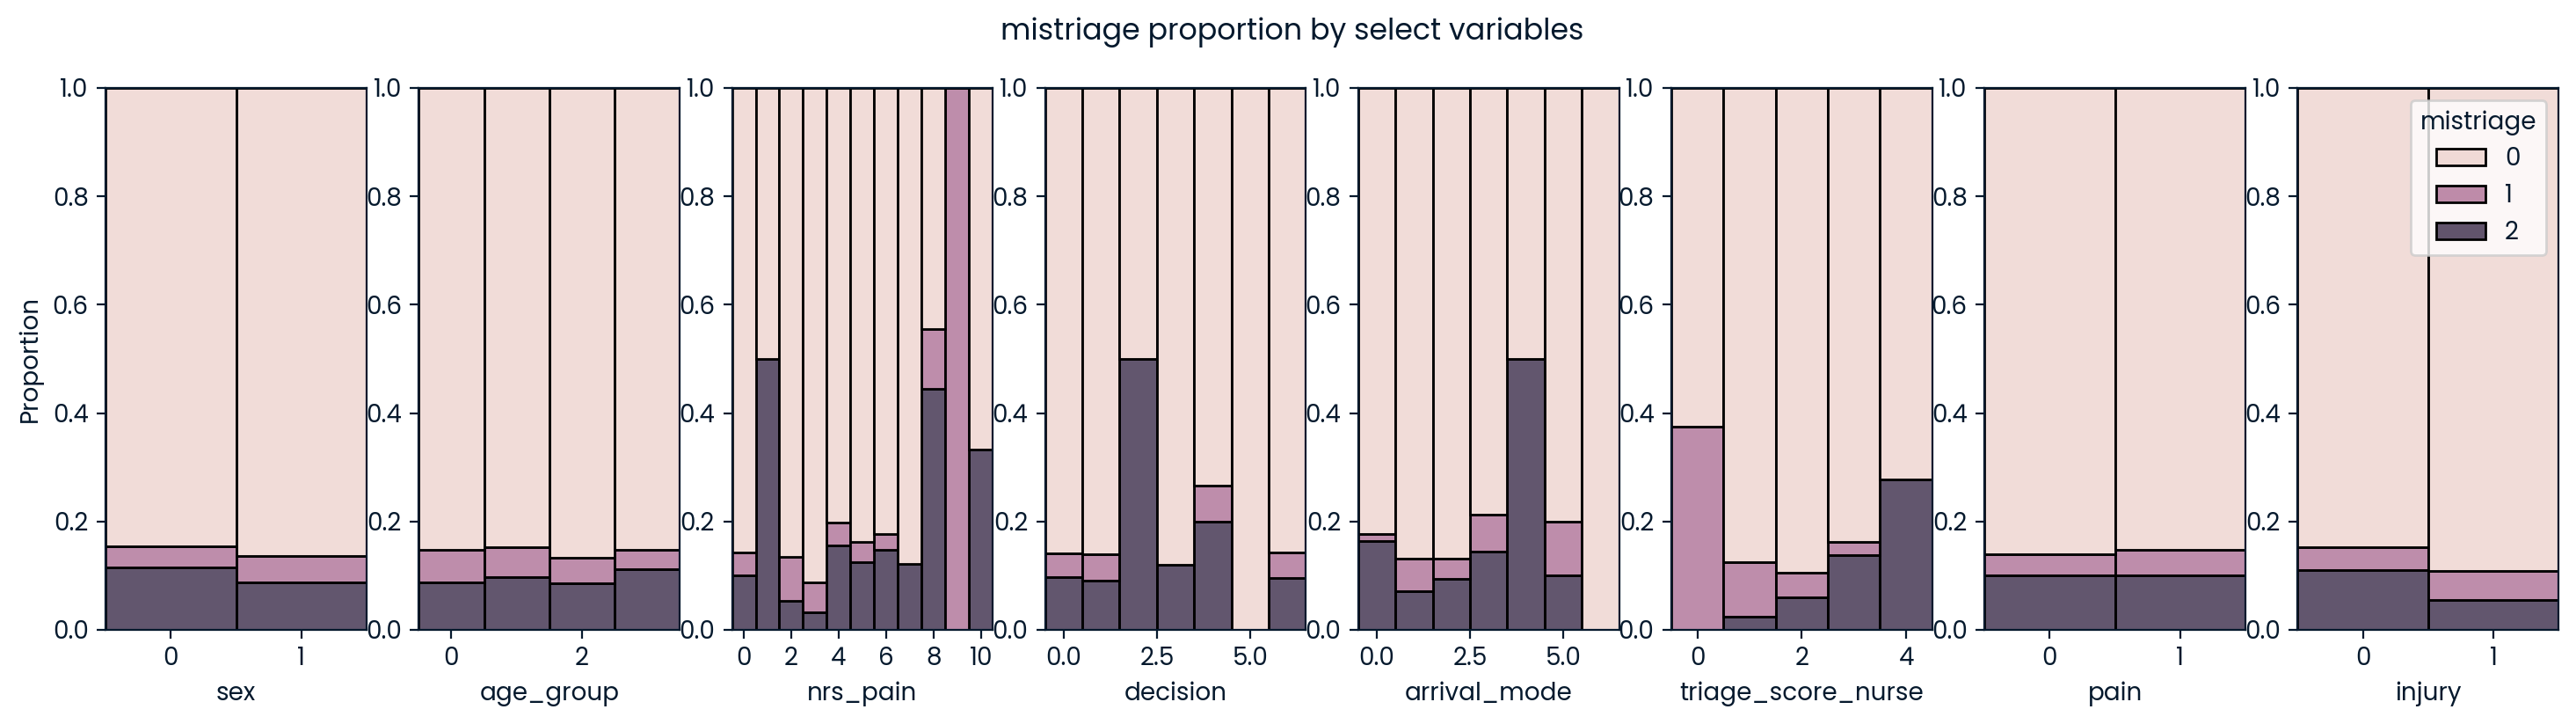

In [21]:
plt.clf()
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 8, figsize=(18, 4))
sns.histplot(dataTriage, x="sex", hue="mistriage", multiple="fill", bins=2, ax=ax0, legend=False)
sns.histplot(dataTriage, x="age_group", hue="mistriage", multiple="fill", ax=ax1, legend=False)
sns.histplot(dataTriage, x="nrs_pain", hue="mistriage", multiple="fill", bins=11, ax=ax2, legend=False)
sns.histplot(dataTriage, x="decision", hue="mistriage", multiple="fill", bins=7, ax=ax3, legend=False)
sns.histplot(dataTriage, x="arrival_mode", hue="mistriage", multiple="fill", bins=7, ax=ax4,legend=False)
sns.histplot(dataTriage, x="triage_score_nurse", hue="mistriage", multiple="fill", bins=5, ax=ax5,legend=False)
sns.histplot(dataTriage, x="pain", hue="mistriage", multiple="fill", bins=2, ax=ax6,legend=False)
sns.histplot(dataTriage, x="injury", hue="mistriage", multiple="fill", bins=2, ax=ax7)
ax0.set_xticks([0,1])
ax2.set_xticks([0,2,4,6,8,10])
ax6.set_xticks([0,1])
ax7.set_xticks([0,1])
ax0.set_xticklabels(ax0.get_xticklabels(), rotation= 0)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation= 0)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation= 0)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation= 0)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation= 0)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation= 0)
ax7.set_xticklabels(ax7.get_xticklabels(), rotation= 0)
ax0.set_ylabel('Proportion')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax7.set_ylabel('')
fig.suptitle("mistriage proportion by select variables")
plt.show()

Results show that most of the cases reported correctly triaged irrespective of the feature. However, around half of the cases with `nrs_pain` of 1 and 8 are undertriaged (`mistriage`=2). All cases with `nrs_pain` of 9 are overtriaged (`mistriage`=1). Cases in which patients are advised to be admitted to the ICU (`decision`=2) are also undertriaged. The same finding was observed for cases in which patients arrived using public transportation. Most of the cases with nurse-based KTAS of 1-2 (these are 0 and 1 in the plot since I subtracted 1 from each of the score) are overtriaged. By  contrast, cases with nurse-based KTAS of 4-5 (the emergency cases) tend to be undertriaged. These include cases wherein patients are advised to be admitted in the ICU, then only to find out that it is deemed inappropriate. 

Undertriaging, defined as the underestimation of acuity or resource needs, in emergency medical settings reveals a huge challenge to healthcare resource optimization [[2](https://www.sciencedirect.com/science/article/abs/pii/S0735675723005375)]. However, the most concerning consequence of undertriaging is delayed treatment, which significantly increases the risk of mortality. Patients with life-threatening conditions may not receive timely interventions, resulting in poorer outcomes or death [[3](https://www.sciencedirect.com/science/article/abs/pii/S0735675723005375)]. Undertriage is a key factor in higher rates of complications and mortality, particularly in time-sensitive emergencies.The same logic follows for overtriaging, wherein patients are are assigned a higher level of care than their clinical condition requires. Overtriage typically leads to patients receiving unnecessary diagnostic tests, treatments, and hospitalizations [[4](https://www.researchgate.net/publication/256481161_The_Cost_Of_Overtriage_More_Than_One-Third_Of_Low-Risk_Injured_Patients_Were_Taken_To_Major_Trauma_Centers)].   

# Modeling
Prior to ML modeling, columns `sbp` and `dbp` will undergo (natural) logarithmic transformation.

In [22]:
print(dataTriage['length_stay_min'].min(), dataTriage['length_stay_min'].max())

0 709510


Since the minimum of `length_stay_min` is 0, the transformation function for this column will be `ln(z+1)`.

In [23]:
# transform sbp, dbp, and length_stay_min using ln(z)
for bp in ['sbp', 'dbp', 'length_stay_min']:
    if bp=='length_stay_min':
        dataTriage[bp] = dataTriage[bp].apply(lambda z: math.log(z + 1))
    else:
        dataTriage[bp] = dataTriage[bp].apply(lambda z: math.log(z))

I then used `XGBClassifier` from the `xgboost` library to build the triage classifier; its hyperparameters will be optimized using Bayesian optimization (via the library `bayesian-optimization`). In the classifier, the `mistriage` will be predicted. Train-test split ratio is set to 0.8-0.2. Furthermore, the XGBoost model is to constructed, the keyword argument `enable_categorical` in the XGBoost model is set to `True`.

Based on the exploratory data analysis, the dataset exhibits **class imbalance**, with a strong bias towards correctly triaged cases as the majority outcome. Hence, I implemented mitigation strategies in the XGBoost model by per-sample weighted loss correction (one that uses class weight scaling). This is similar to telling the model to put importance on the minority classes -- by multiplying the loss function with a custom weight for each class. After getting the optimal hyperparameters via Bayesian optimization, per-sample weighing is performed together with `k`-fold stratified cross-validation (`k`=5). 

To assess the quality of the model in the context of a dataset with class imbalance, the **balanced accuracy** -- a metric that accounts for class imbalance by taking the mean of recall across all classes [[5](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)] -- is also computed. The best model will be the one with the highest balanced accuracy across all folds. The average test set and balanced accuracies across all folds are also reported. 

The model is safe from the risk of class imbalance bias and overfitting _if_ the average test set accuracy and the average balanced accuracy are nearly similar.

In [32]:
# the dataTriage dataframe is split into features and target variable
X = dataTriage.drop(columns=['mistriage'], axis=1)
y = dataTriage['mistriage']


# define Bayesian Optimization Function
def optimize_xgb(max_depth, learning_rate, n_estimators):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    balanced_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

        model = XGBClassifier(
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42,
            enable_categorical=True
        )

        model.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = model.predict(X_test)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        balanced_scores.append(balanced_acc)

    return np.mean(balanced_scores)

# perform Bayesian optimization
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300)
}

optimizer = BayesianOptimization(
    f=optimize_xgb,
    pbounds=pbounds,
    random_state=42
)

optimizer.maximize(init_points=2, n_iter=10)

# retrieve best parameters
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

print("Best Bayesian Optimization Parameters:", best_params)

# final model training with best parameters
best_model = None
best_score = -np.inf
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
balanced_scores = []
accuracy_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Training Fold {fold + 1}/{skf.n_splits}...")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    model = XGBClassifier(
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        enable_categorical=True
    )

    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    balanced_scores.append(balanced_acc)
    accuracy_scores.append(acc)

    print(f"Fold {fold + 1} Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Fold {fold + 1} Test Set Accuracy: {acc:.4f}")

    if balanced_acc > best_score:
        best_score = balanced_acc
        best_model = model

print(f"\nAverage Balanced Accuracy Across Folds (Final Model): {np.mean(balanced_scores):.4f}")
print(f"Average Test Set Accuracy Across Folds (Final Model): {np.mean(accuracy_scores):.4f}")
print(f"\nBest Balanced Accuracy Score: {best_score:.4f}")

# access best model
best_model


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.8707    | 0.1186    | 9.655     | 233.0     |
| 2         | 0.9032    | 0.1836    | 4.092     | 89.0      |
| 3         | 0.885     | 0.1178    | 5.078     | 88.1      |
| 4         | 0.9092    | 0.1014    | 4.17      | 88.95     |
| 5         | 0.9092    | 0.1311    | 4.156     | 88.57     |
| 6         | 0.9078    | 0.03389   | 4.6       | 89.32     |
| 7         | 0.885     | 0.1411    | 5.375     | 89.72     |
| 8         | 0.8737    | 0.2606    | 3.382     | 88.05     |
| 9         | 0.9154    | 0.2638    | 4.541     | 88.71     |
| 10        | 0.891     | 0.245     | 4.178     | 60.03     |
| 11        | 0.8823    | 0.2802    | 6.761     | 159.5     |
| 12        | 0.8674    | 0.2795    | 7.085     | 122.1     |
Best Bayesian Optimization Parameters: {'learning_rate': 0.2638425740497244, 'max_depth': 4, 'n_estimators': 88}
Training Fold 1/5..

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2638425740497244, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=88, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Results above shows that the average test set accuracy (0.985) and the average balanced accuracy (0.915) are **_aptly close_**, impyling that I've addressed the concern of creating a biased model. With a high balanced accuracy, this also means that the XGBoost-based model also learns from the minority classes (overtriaged and undertriaged cases).

## Takeaways and recommendations
I've successfully constructed a triage accuracy predictor that despite the complication of a dataset with class imbalance, I was able to spew out a model with very good average test set and balanced accuracies of ~98% and ~92%, respectively. Some considerations to take note of include exploring other machine learning methods like the Kolmogorov-Arnold networks and LightGBM.


If you have questions and/or feedback, please send them over at jprmaulion[at]gmail[dot]com. Cheerio for now!